옵션값을 입력하세요 0:SGD, 1:adagrad, 2:SGD+Dropout, 3:adagrad+Dropout
3


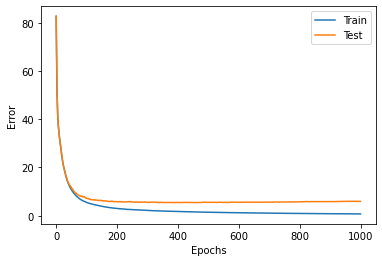

In [5]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

print("옵션값을 입력하세요 0:SGD, 1:adagrad, 2:SGD+Dropout, 3:adagrad+Dropout")
overfitting=input()

if overfitting=='0':
    iris_data = datasets.load_iris()
    input_data = iris_data.data
    correct = iris_data.target
    n_data = len(correct)  # 샘플 수

# -- 입력 데이터 표준화 --
    ave_input = np.average(input_data, axis=0)
    std_input = np.std(input_data, axis=0)
    input_data = (input_data - ave_input) / std_input

# -- 정답을 원-핫 인코딩으로 변경 --
    correct_data = np.zeros((n_data, 3))
    for i in range(n_data):
        correct_data[i, correct[i]] = 1.0

# -- 훈련 데이터와 테스트 데이터 --
    index = np.arange(n_data)
    index_train = index[index%2 == 0]
    index_test = index[index%2 != 0]

    input_train = input_data[index_train, :]  # 훈련데이터 입력
    correct_train = correct_data[index_train, :]  # 훈련데이터 정답
    input_test = input_data[index_test, :]  # 테스트데이터 입력
    correct_test = correct_data[index_test, :]  # 테스트데이터 정답

    n_train = input_train.shape[0]  # 훈련데이터 샘플 수
    n_test = input_test.shape[0]  # 테스트데이터 샘플 수

# -- 각 설정 값 --
    n_in = 4  # 입력층 뉴런 수
    n_mid = 25  # 은닉층 뉴런 수
    n_out = 3  # 출력층 뉴런 수

    wb_width = 0.1  # 가중치와 편향 설정을 위한 정규분포 표준편차
    eta = 0.01  # 학습률
    epoch = 1000
    batch_size = 8
    interval = 100  # 경과 표시 간격
    n_batch = n_train // batch_size  # 1에포크 당 배치 수
   
    #2) 클래스 구현
    class BaseLayer:
        def __init__(self,n_upper,n): #상위층에 뉴런의 갯수, 현재 층의 뉴런의 갯수
            self.w=wb_width*np.random.randn(n_upper,n) # 가중치와 편향 랜덤 주기
            self.b=wb_width*np.random.randn(n)
        
        def update(self,eta):
            self.w -=eta*self.grad_w # 가중치와 편향의 기울기 * 학습률
            self.b -=eta*self.grad_b

    class MiddleLayer(BaseLayer): #상속 은닉층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b # 행렬 곱 가중치와 입력들어온 x값
            self.y=np.where(self.u<=0,0,self.u) # (활성화함수)출력 하는거임 ReLu 함수 0보다 작으면 0, 아니면 그 자신
        
        #역방향
        def backward(self,grad_y):
            delta=grad_y*np.where(self.u<=0,0,1) # 출력기울기*relu 함수 미분
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬

    class OutputLayer(BaseLayer): #상속 출력층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b
            self.y=np.exp(self.u)/np.sum(np.exp(self.u),axis=1,keepdims=True)
        
        #역방향
        def backward(self,t): # t는 정답 정답을 입력으로 받음
            delta=self.y-t
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬
        
    #3)신경망 구현
    #학습 알고리즘 - 미니배치 사용 
    
    middle_layer_1=MiddleLayer(n_in,n_mid)
    middle_layer_2=MiddleLayer(n_mid,n_mid)
    output_layer=OutputLayer(n_mid,n_out)

    #순전파
    def forward_propagation(x):
        middle_layer_1.forward(x)
        middle_layer_2.forward(middle_layer_1.y) #앞 뉴런의 출력
        output_layer.forward(middle_layer_2.y) #위와 동일
    
    #역전파
    def back_propagation(t):
        output_layer.backward(t)
        middle_layer_2.backward(output_layer.grad_x) #입력 기울기
        middle_layer_1.backward(middle_layer_2.grad_x)
    
    #보정
    def update_wb():
        middle_layer_1.update(eta)
        middle_layer_2.update(eta)
        output_layer.update(eta)
    
    #교차엔트로피 에러 계산하는 함수
    def get_error(t,batch_size): #8개를 다 구한다음 배치사이즈 만큼 나눠줌
        return -np.sum(t*np.log(output_layer.y+1e-7))
    
    
    # 학습 for문 두개로 / 후 출력

    train_error_x=[] # 데이터의 횟수(갯수)
    train_error_y=[] # 데이터의 오차값
    test_error_x=[]
    test_error_y=[]

    for i in range(epoch):
        forward_propagation(input_train)
        error_train=get_error(correct_train,n_train) # 한번에 다 보겠다. 그래서 n_train 75개
        forward_propagation(input_test)
        error_test=get_error(correct_test,n_test)
    
        train_error_x.append(i)
        train_error_y.append(error_train)
        test_error_x.append(i)
        test_error_y.append(error_test)
    
        index_random=np.arange(n_train)
        np.random.shuffle(index_random)
        for j in range(n_batch):
            mb_index=index_random[j*batch_size:(j+1)*batch_size] # 0 부터 8 까지 0~7 j 가 1이면 9~15
            x= input_train[mb_index,:]
            t= correct_train[mb_index,:] #목표출력(정답)
        
            forward_propagation(x)
            back_propagation(t)
            update_wb()

    plt.plot(train_error_x,train_error_y,label="Train")
    plt.plot(test_error_x,test_error_y,label="Test")
    plt.legend() # 각 그래프 이름
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.show()

if overfitting=='1':
    iris_data = datasets.load_iris()
    input_data = iris_data.data
    correct = iris_data.target
    n_data = len(correct)  # 샘플 수

# -- 입력 데이터 표준화 --
    ave_input = np.average(input_data, axis=0)
    std_input = np.std(input_data, axis=0)
    input_data = (input_data - ave_input) / std_input

# -- 정답을 원-핫 인코딩으로 변경 --
    correct_data = np.zeros((n_data, 3))
    for i in range(n_data):
        correct_data[i, correct[i]] = 1.0

# -- 훈련 데이터와 테스트 데이터 --
    index = np.arange(n_data)
    index_train = index[index%2 == 0]
    index_test = index[index%2 != 0]

    input_train = input_data[index_train, :]  # 훈련데이터 입력
    correct_train = correct_data[index_train, :]  # 훈련데이터 정답
    input_test = input_data[index_test, :]  # 테스트데이터 입력
    correct_test = correct_data[index_test, :]  # 테스트데이터 정답

    n_train = input_train.shape[0]  # 훈련데이터 샘플 수
    n_test = input_test.shape[0]  # 테스트데이터 샘플 수

# -- 각 설정 값 --
    n_in = 4  # 입력층 뉴런 수
    n_mid = 25  # 은닉층 뉴런 수
    n_out = 3  # 출력층 뉴런 수

    wb_width = 0.1  # 가중치와 편향 설정을 위한 정규분포 표준편차
    eta = 0.01  # 학습률
    epoch = 1000
    batch_size = 8
    interval = 100  # 경과 표시 간격
    n_batch = n_train // batch_size  # 1에포크 당 배치 수
   
    #2) 클래스 구현
    class BaseLayer:
        def __init__(self,n_upper,n): #상위층에 뉴런의 갯수, 현재 층의 뉴런의 갯수
            self.w=wb_width*np.random.randn(n_upper,n) # 가중치와 편향 랜덤 주기
            self.b=wb_width*np.random.randn(n)
            self.h_w=np.zeros((n_upper,n)) + 1e-8 #.h는 아다그라드를 위해
            self.h_b=np.zeros((n)) + 1e-8
        
        def update(self,eta):
            self.h_w+=self.grad_w * self.grad_w
            self.h_b+=self.grad_b * self.grad_b
        
            self.w -=eta/np.sqrt(self.h_w)*self.grad_w # 가중치와 편향의 기울기 * 학습률
            self.b -=eta/np.sqrt(self.h_b)*self.grad_b

    class MiddleLayer(BaseLayer): #상속 은닉층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b # 행렬 곱 가중치와 입력들어온 x값
            self.y=np.where(self.u<=0,0,self.u) # (활성화함수)출력 하는거임 ReLu 함수 0보다 작으면 0, 아니면 그 자신
        
        #역방향
        def backward(self,grad_y):
            delta=grad_y*np.where(self.u<=0,0,1) # 출력기울기*relu 함수 미분
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬

    class OutputLayer(BaseLayer): #상속 출력층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b
            self.y=np.exp(self.u)/np.sum(np.exp(self.u),axis=1,keepdims=True)
        
        #역방향
        def backward(self,t): # t는 정답 정답을 입력으로 받음
            delta=self.y-t
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬
        
    #3)신경망 구현
    #학습 알고리즘 - 미니배치 사용 
    
    middle_layer_1=MiddleLayer(n_in,n_mid)
    middle_layer_2=MiddleLayer(n_mid,n_mid)
    output_layer=OutputLayer(n_mid,n_out)

    #순전파
    def forward_propagation(x):
        middle_layer_1.forward(x)
        middle_layer_2.forward(middle_layer_1.y) #앞 뉴런의 출력
        output_layer.forward(middle_layer_2.y) #위와 동일
    
    #역전파
    def back_propagation(t):
        output_layer.backward(t)
        middle_layer_2.backward(output_layer.grad_x) #입력 기울기
        middle_layer_1.backward(middle_layer_2.grad_x)
    
    #보정
    def update_wb():
        middle_layer_1.update(eta)
        middle_layer_2.update(eta)
        output_layer.update(eta)
    
    #교차엔트로피 에러 계산하는 함수
    def get_error(t,batch_size): #8개를 다 구한다음 배치사이즈 만큼 나눠줌
        return -np.sum(t*np.log(output_layer.y+1e-7))
    
    
    # 학습 for문 두개로 / 후 출력

    train_error_x=[] # 데이터의 횟수(갯수)
    train_error_y=[] # 데이터의 오차값
    test_error_x=[]
    test_error_y=[]

    for i in range(epoch):
        forward_propagation(input_train)
        error_train=get_error(correct_train,n_train) # 한번에 다 보겠다. 그래서 n_train 75개
        forward_propagation(input_test)
        error_test=get_error(correct_test,n_test)
    
        train_error_x.append(i)
        train_error_y.append(error_train)
        test_error_x.append(i)
        test_error_y.append(error_test)
    
        index_random=np.arange(n_train)
        np.random.shuffle(index_random)
        for j in range(n_batch):
            mb_index=index_random[j*batch_size:(j+1)*batch_size] # 0 부터 8 까지 0~7 j 가 1이면 9~15
            x= input_train[mb_index,:]
            t= correct_train[mb_index,:] #목표출력(정답)
        
            forward_propagation(x)
            back_propagation(t)
            update_wb()

    plt.plot(train_error_x,train_error_y,label="Train")
    plt.plot(test_error_x,test_error_y,label="Test")
    plt.legend() # 각 그래프 이름
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.show()
    
    
if overfitting=='2':
    iris_data = datasets.load_iris()
    input_data = iris_data.data
    correct = iris_data.target
    n_data = len(correct)  # 샘플 수

# -- 입력 데이터 표준화 --
    ave_input = np.average(input_data, axis=0)
    std_input = np.std(input_data, axis=0)
    input_data = (input_data - ave_input) / std_input

# -- 정답을 원-핫 인코딩으로 변경 --
    correct_data = np.zeros((n_data, 3))
    for i in range(n_data):
        correct_data[i, correct[i]] = 1.0

# -- 훈련 데이터와 테스트 데이터 --
    index = np.arange(n_data)
    index_train = index[index%2 == 0]
    index_test = index[index%2 != 0]

    input_train = input_data[index_train, :]  # 훈련데이터 입력
    correct_train = correct_data[index_train, :]  # 훈련데이터 정답
    input_test = input_data[index_test, :]  # 테스트데이터 입력
    correct_test = correct_data[index_test, :]  # 테스트데이터 정답

    n_train = input_train.shape[0]  # 훈련데이터 샘플 수
    n_test = input_test.shape[0]  # 테스트데이터 샘플 수

# -- 각 설정 값 --
    n_in = 4  # 입력층 뉴런 수
    n_mid = 25  # 은닉층 뉴런 수
    n_out = 3  # 출력층 뉴런 수

    wb_width = 0.1  # 가중치와 편향 설정을 위한 정규분포 표준편차
    eta = 0.01  # 학습률
    epoch = 1000
    batch_size = 8
    interval = 100  # 경과 표시 간격
    n_batch = n_train // batch_size  # 1에포크 당 배치 수
   
    #2) 클래스 구현
    class BaseLayer:
        def __init__(self,n_upper,n): #상위층에 뉴런의 갯수, 현재 층의 뉴런의 갯수
            self.w=wb_width*np.random.randn(n_upper,n) # 가중치와 편향 랜덤 주기
            self.b=wb_width*np.random.randn(n)
        
        def update(self,eta):
            self.w -=eta*self.grad_w # 가중치와 편향의 기울기 * 학습률
            self.b -=eta*self.grad_b

    class MiddleLayer(BaseLayer): #상속 은닉층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b # 행렬 곱 가중치와 입력들어온 x값
            self.y=np.where(self.u<=0,0,self.u) # (활성화함수)출력 하는거임 ReLu 함수 0보다 작으면 0, 아니면 그 자신
        
        #역방향
        def backward(self,grad_y):
            delta=grad_y*np.where(self.u<=0,0,1) # 출력기울기*relu 함수 미분
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬
            
    class Dropout(): #드롭 아웃층
        def __init__(self,dropout_ratio): #ratio는 얼마만큼 비율로 없애줄거냐?
            self.dropout_ratio=dropout_ratio
        
        #순방향 
        def forward(self,x,is_train):
            if is_train:
                rand=np.random.rand(*x.shape) #은닉층 뉴런의 갯수만큼 생김.
                self.dropout=np.where(rand>self.dropout_ratio,1,0)
                self.y=x*self.dropout
            else:
                self.y=x*(1-self.dropout_ratio)
        
    #역방향
        def backward(self,grad_y):
           self.grad_x=grad_y*self.dropout #드롭아웃이 1이면 전달 0이면 전달  X

    class OutputLayer(BaseLayer): #상속 출력층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b
            self.y=np.exp(self.u)/np.sum(np.exp(self.u),axis=1,keepdims=True)
        
        #역방향
        def backward(self,t): # t는 정답 정답을 입력으로 받음
            delta=self.y-t
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬
        
    #3)신경망 구현
    #학습 알고리즘 - 미니배치 사용 
    
    middle_layer_1=MiddleLayer(n_in,n_mid)
    dropout1=Dropout(0.5)
    middle_layer_2=MiddleLayer(n_mid,n_mid)
    dropout2=Dropout(0.5)
    output_layer=OutputLayer(n_mid,n_out)

    #순전파
    def forward_propagation(x,is_train):
        middle_layer_1.forward(x)
        dropout1.forward(middle_layer_1.y,is_train)
        middle_layer_2.forward(middle_layer_1.y) #앞 뉴런의 출력
        dropout2.forward(middle_layer_2.y,is_train)
        output_layer.forward(middle_layer_2.y) #위와 동일
    
    #역전파
    def back_propagation(t):
        output_layer.backward(t)
        dropout2.backward(output_layer.grad_x)
        middle_layer_2.backward(dropout2.grad_x) #입력 기울기
        dropout1.backward(middle_layer_2.grad_x)
        middle_layer_1.backward(dropout1.grad_x)
    
    #보정
    def update_wb():
        middle_layer_1.update(eta)
        middle_layer_2.update(eta)
        output_layer.update(eta)
    
    #교차엔트로피 에러 계산하는 함수
    def get_error(t,batch_size): #8개를 다 구한다음 배치사이즈 만큼 나눠줌
        return -np.sum(t*np.log(output_layer.y+1e-7))
    
    
    # 학습 for문 두개로 / 후 출력

    train_error_x=[] # 데이터의 횟수(갯수)
    train_error_y=[] # 데이터의 오차값
    test_error_x=[]
    test_error_y=[]

    for i in range(epoch):
        forward_propagation(input_train,False)
        error_train=get_error(correct_train,n_train) # 한번에 다 보겠다. 그래서 n_train 75개
        forward_propagation(input_test,False)
        error_test=get_error(correct_test,n_test)
    
        train_error_x.append(i)
        train_error_y.append(error_train)
        test_error_x.append(i)
        test_error_y.append(error_test)
    
        index_random=np.arange(n_train)
        np.random.shuffle(index_random)
        for j in range(n_batch):
            mb_index=index_random[j*batch_size:(j+1)*batch_size] # 0 부터 8 까지 0~7 j 가 1이면 9~15
            x= input_train[mb_index,:]
            t= correct_train[mb_index,:] #목표출력(정답)
        
            forward_propagation(x,True)
            back_propagation(t)
            update_wb()

    plt.plot(train_error_x,train_error_y,label="Train")
    plt.plot(test_error_x,test_error_y,label="Test")
    plt.legend() # 각 그래프 이름
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.show()
    
if overfitting=='3':
    iris_data = datasets.load_iris()
    input_data = iris_data.data
    correct = iris_data.target
    n_data = len(correct)  # 샘플 수

# -- 입력 데이터 표준화 --
    ave_input = np.average(input_data, axis=0)
    std_input = np.std(input_data, axis=0)
    input_data = (input_data - ave_input) / std_input

# -- 정답을 원-핫 인코딩으로 변경 --
    correct_data = np.zeros((n_data, 3))
    for i in range(n_data):
        correct_data[i, correct[i]] = 1.0

# -- 훈련 데이터와 테스트 데이터 --
    index = np.arange(n_data)
    index_train = index[index%2 == 0]
    index_test = index[index%2 != 0]

    input_train = input_data[index_train, :]  # 훈련데이터 입력
    correct_train = correct_data[index_train, :]  # 훈련데이터 정답
    input_test = input_data[index_test, :]  # 테스트데이터 입력
    correct_test = correct_data[index_test, :]  # 테스트데이터 정답

    n_train = input_train.shape[0]  # 훈련데이터 샘플 수
    n_test = input_test.shape[0]  # 테스트데이터 샘플 수

# -- 각 설정 값 --
    n_in = 4  # 입력층 뉴런 수
    n_mid = 25  # 은닉층 뉴런 수
    n_out = 3  # 출력층 뉴런 수

    wb_width = 0.1  # 가중치와 편향 설정을 위한 정규분포 표준편차
    eta = 0.01  # 학습률
    epoch = 1000
    batch_size = 8
    interval = 100  # 경과 표시 간격
    n_batch = n_train // batch_size  # 1에포크 당 배치 수
   
    #2) 클래스 구현
    class BaseLayer:
        def __init__(self,n_upper,n): #상위층에 뉴런의 갯수, 현재 층의 뉴런의 갯수
            self.w=wb_width*np.random.randn(n_upper,n) # 가중치와 편향 랜덤 주기
            self.b=wb_width*np.random.randn(n)
            self.h_w=np.zeros((n_upper,n)) + 1e-8 #.h는 아다그라드를 위해
            self.h_b=np.zeros((n)) + 1e-8
        
        def update(self,eta):
            self.h_w+=self.grad_w * self.grad_w
            self.h_b+=self.grad_b * self.grad_b
        
            self.w -=eta/np.sqrt(self.h_w)*self.grad_w # 가중치와 편향의 기울기 * 학습률
            self.b -=eta/np.sqrt(self.h_b)*self.grad_b

    class MiddleLayer(BaseLayer): #상속 은닉층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b # 행렬 곱 가중치와 입력들어온 x값
            self.y=np.where(self.u<=0,0,self.u) # (활성화함수)출력 하는거임 ReLu 함수 0보다 작으면 0, 아니면 그 자신
        
        #역방향
        def backward(self,grad_y):
            delta=grad_y*np.where(self.u<=0,0,1) # 출력기울기*relu 함수 미분
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬
            
    class Dropout(): #드롭 아웃층
        def __init__(self,dropout_ratio): #ratio는 얼마만큼 비율로 없애줄거냐?
            self.dropout_ratio=dropout_ratio
        
        #순방향 
        def forward(self,x,is_train):
            if is_train:
                rand=np.random.rand(*x.shape) #은닉층 뉴런의 갯수만큼 생김.
                self.dropout=np.where(rand>self.dropout_ratio,1,0)
                self.y=x*self.dropout
            else:
                self.y=x*(1-self.dropout_ratio)
        
    #역방향
        def backward(self,grad_y):
           self.grad_x=grad_y*self.dropout #드롭아웃이 1이면 전달 0이면 전달  X

    class OutputLayer(BaseLayer): #상속 출력층
        #순방향 
        def forward(self,x):
            self.x=x
            self.u=np.dot(x,self.w) + self.b
            self.y=np.exp(self.u)/np.sum(np.exp(self.u),axis=1,keepdims=True)
        
        #역방향
        def backward(self,t): # t는 정답 정답을 입력으로 받음
            delta=self.y-t
            self.grad_w=np.dot(self.x.T,delta)#가중치와 편향와 입력의 기울기를 구해야함.
            self.grad_b=np.sum(delta,axis=0)
            self.grad_x=np.dot(delta,self.w.T) #T는 전치행렬
        
    #3)신경망 구현
    #학습 알고리즘 - 미니배치 사용 
    
    middle_layer_1=MiddleLayer(n_in,n_mid)
    dropout1=Dropout(0.5)
    middle_layer_2=MiddleLayer(n_mid,n_mid)
    dropout2=Dropout(0.5)
    output_layer=OutputLayer(n_mid,n_out)

    #순전파
    def forward_propagation(x,is_train):
        middle_layer_1.forward(x)
        dropout1.forward(middle_layer_1.y,is_train)
        middle_layer_2.forward(middle_layer_1.y) #앞 뉴런의 출력
        dropout2.forward(middle_layer_2.y,is_train)
        output_layer.forward(middle_layer_2.y) #위와 동일
    
    #역전파
    def back_propagation(t):
        output_layer.backward(t)
        dropout2.backward(output_layer.grad_x)
        middle_layer_2.backward(dropout2.grad_x) #입력 기울기
        dropout1.backward(middle_layer_2.grad_x)
        middle_layer_1.backward(dropout1.grad_x)
    
    #보정
    def update_wb():
        middle_layer_1.update(eta)
        middle_layer_2.update(eta)
        output_layer.update(eta)
    
    #교차엔트로피 에러 계산하는 함수
    def get_error(t,batch_size): #8개를 다 구한다음 배치사이즈 만큼 나눠줌
        return -np.sum(t*np.log(output_layer.y+1e-7))
    
    
    # 학습 for문 두개로 / 후 출력

    train_error_x=[] # 데이터의 횟수(갯수)
    train_error_y=[] # 데이터의 오차값
    test_error_x=[]
    test_error_y=[]

    for i in range(epoch):
        forward_propagation(input_train,False)
        error_train=get_error(correct_train,n_train) # 한번에 다 보겠다. 그래서 n_train 75개
        forward_propagation(input_test,False)
        error_test=get_error(correct_test,n_test)
    
        train_error_x.append(i)
        train_error_y.append(error_train)
        test_error_x.append(i)
        test_error_y.append(error_test)
    
        index_random=np.arange(n_train)
        np.random.shuffle(index_random)
        for j in range(n_batch):
            mb_index=index_random[j*batch_size:(j+1)*batch_size] # 0 부터 8 까지 0~7 j 가 1이면 9~15
            x= input_train[mb_index,:]
            t= correct_train[mb_index,:] #목표출력(정답)
        
            forward_propagation(x,True)
            back_propagation(t)
            update_wb()

    plt.plot(train_error_x,train_error_y,label="Train")
    plt.plot(test_error_x,test_error_y,label="Test")
    plt.legend() # 각 그래프 이름
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.show()